## This is the first notebook. Here we try to make the optimal portfolio using the assests in Data\

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import os
import datetime as dt

import pandas_datareader as pdr

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
data_frames = [ pd.read_csv(os.getcwd()+'\\Data\\'+'AAL.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "AAL"}),\
                pd.read_csv(os.getcwd()+'\\Data\\'+'AAPL.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "AAPL"}),\
                pd.read_csv(os.getcwd()+'\\Data\\'+'BAC.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "BAC"}),\
                pd.read_csv(os.getcwd()+'\\Data\\'+'F.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "F"}),\
                pd.read_csv(os.getcwd()+'\\Data\\'+'PFE.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "PFE"})]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                            how='outer'), data_frames)
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
# df_merged = df_merged.set_index('Date')
df_merged.head()

,Date,AAL,AAPL,BAC,F,PFE
0,2019-11-29,28.634182,65.834587,31.816368,8.863864,33.790043
1,2019-12-02,27.976612,65.073410,31.921404,8.814946,33.588291
2,2019-12-03,27.189522,63.913139,31.358027,8.697544,33.377762
3,2019-12-04,27.279188,64.477257,31.654043,8.756245,33.456711
4,2019-12-05,27.139706,65.423203,31.769257,8.736678,33.360218


In [15]:
# pd.DataFrame(index=pd.date_range(start=start_date,end=end_date)).rename_axis('Date')
range(len(tickers))

range(0, 5)

In [29]:
### Test automating the asset data retrieval using yfinance library
tickers = ['AAL','AAPL','BAC','F','PFE']
start_date = "2021-11-20"
end_date = "2021-11-28"

def fetch_data(tickers=["TSLA","AAPL","MSFT"],start_date = dt.datetime.today()-dt.timedelta(weeks=104),end_date = dt.datetime.today()):
    for i in range(len(tickers)):

        if i == 0:
            print(i)
            res = pdr.get_data_yahoo(tickers[i],start=start_date,end=end_date,)[["Adj Close"]].rename(columns={"Adj Close": tickers[i]}).reset_index()
        else:
            curr = pdr.get_data_yahoo(tickers[i],start=start_date,end=end_date,)[["Adj Close"]].rename(columns={"Adj Close": tickers[i]}).reset_index()
            res = pd.merge(res,curr,on=['Date'],how='outer')
    return res



df_merged = fetch_data()

0


<AxesSubplot:xlabel='Date', ylabel='value'>

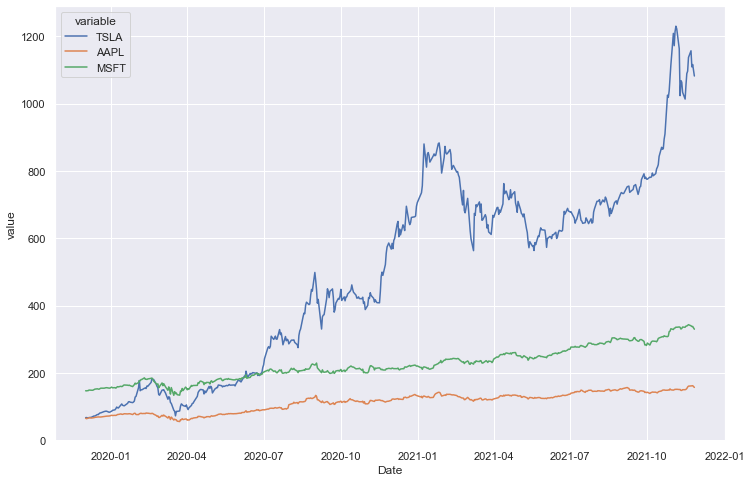

In [30]:
sns.lineplot(x="Date", y="value",
             hue="variable",
             data=pd.melt(df_merged,id_vars='Date'))

In [31]:
# Daily and annual returns
returns_daily = df_merged.set_index("Date").pct_change()
returns_annual = returns_daily.mean() * 250

# Daily and annual covariance of returns
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

<AxesSubplot:xlabel='Date', ylabel='value'>

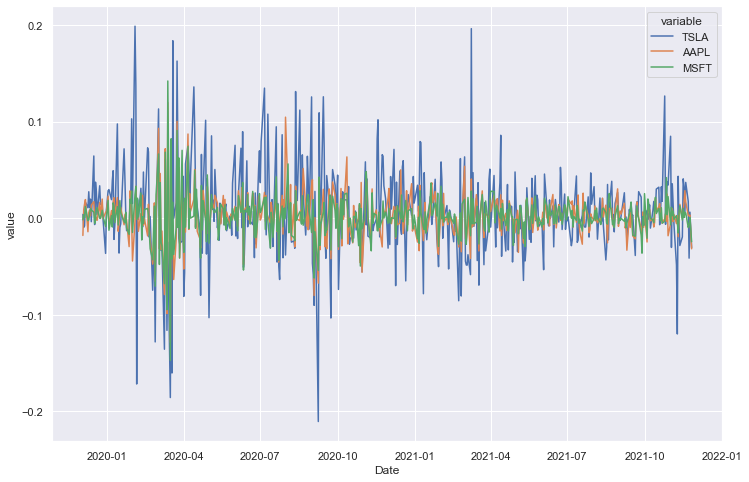

In [32]:
# Daily returns
sns.lineplot(x="Date", y="value",
             hue="variable",
             data=pd.melt(returns_daily.reset_index(), id_vars='Date'))


<AxesSubplot:>

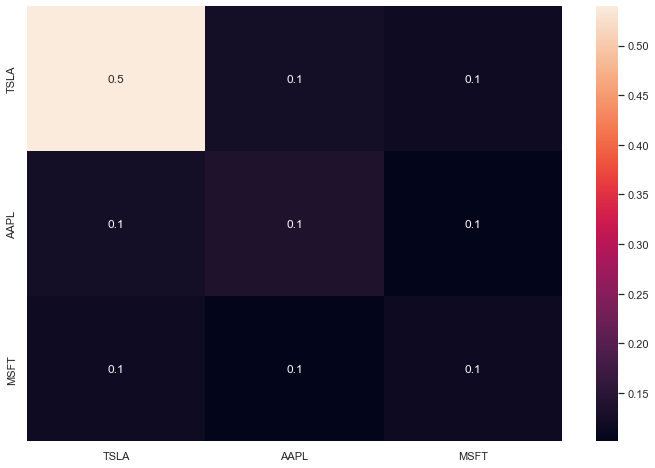

In [33]:
# Covariance matrix
sns.heatmap(cov_annual,annot=True,fmt=".1f")

In [34]:
p_returns = []
p_volatility = []
sharpe_ratios = []
asset_weights = []

# set the number of combinations for imaginary portfolios
n_assets = len(df_merged.columns)-1
n_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

### Simulate different portfolios by giving each asset a random weight. Basically Monte Carlo (MC) method with uniform a priori distribution.

In [35]:
risk_free_rate = 0.01482 # 10 year US bond yield
for i in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= np.sum(w)
    returns = np.dot(w, returns_annual)
    volatility = np.sqrt(np.dot(w.T, np.dot(cov_annual, w)))
    sharpe = (returns-risk_free_rate) / volatility
    sharpe_ratios.append(sharpe)
    p_returns.append(returns)
    p_volatility.append(volatility)
    asset_weights.append(w)

In [36]:
df_w = pd.DataFrame(asset_weights,columns=["Weight: "+ s for s in returns_daily.columns.tolist()])
df_kpi = pd.DataFrame.from_dict({"Returns":p_returns,
"Volatility":p_volatility,
"Sharpe Ratio":sharpe_ratios})
res = pd.concat([df_kpi,df_w],axis=1)
# pd.concat([df_kpi.iloc[0:5,],df_w.iloc[0:5,]],axis=1)
res

,Returns,Volatility,Sharpe Ratio,Weight: TSLA,Weight: AAPL,Weight: MSFT
0,1.040333,0.464914,2.205814,0.462913,0.511562,0.025525
1,0.602086,0.344432,1.705026,0.101450,0.405323,0.493227
2,0.674661,0.357221,1.847153,0.159702,0.464909,0.375389
3,0.692776,0.361895,1.873353,0.173255,0.505544,0.321201
4,0.593323,0.343354,1.684862,0.094100,0.406421,0.499480
...,...,...,...,...,...,...
49995,0.968718,0.434967,2.193033,0.414710,0.210532,0.374758
49996,0.770242,0.378872,1.993870,0.238269,0.495067,0.266665
49997,0.585581,0.341520,1.671236,0.090102,0.342185,0.567713
49998,0.976446,0.437626,2.197367,0.419866,0.244204,0.335930


### Plot the simulated portfolios in the mean-volatility space.

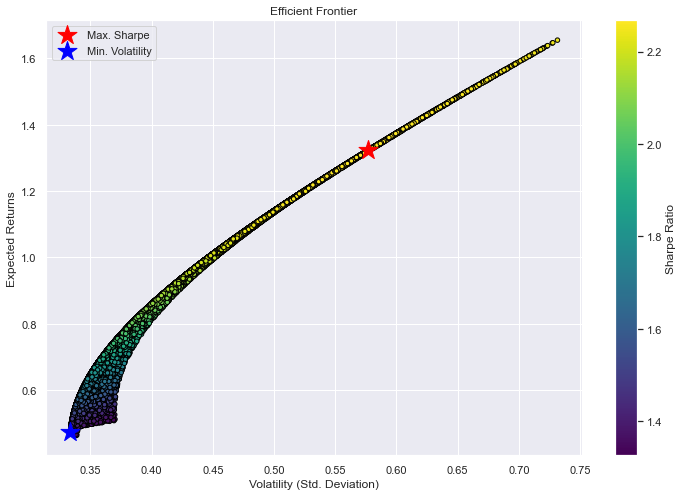

In [37]:
fig, ax = plt.subplots() # Known bug from 2015 onwards, X axis does not show up with pandas+matplotlib when using colourbar
res.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='viridis', edgecolors='black', ax=ax)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# Find the minimum volatiliy and maximum sharpe portfolios
min_volatility_idx = res['Volatility'].argmin()
max_sharpe_idx = res['Sharpe Ratio'].argmax()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df_kpi.loc[max_sharpe_idx]
min_variance_port = df_kpi.loc[min_volatility_idx]

plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='*', s=400,label="Max. Sharpe")
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='*', s=400,label="Min. Volatility")
plt.legend()